In [ ]:
# ----------------------------------------------------------
# 1. Install and Import All Required Libraries
# ----------------------------------------------------------

# Install required packages (Colab already has most of them)
!pip install tensorflow opencv-python matplotlib scikit-learn numpy pillow --quiet

# ----------------------------------------------------------
# IMPORT LIBRARIES
# ----------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import random
import warnings

from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# ----------------------------------------------------------
# Ignore All Warnings
# ----------------------------------------------------------

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("All libraries imported successfully.")

All libraries imported successfully.


MNIST Dataset Loaded Successfully.

Training set images shape: (60000, 28, 28)
Training set labels shape: (60000,)
Testing set images shape:  (10000, 28, 28)
Testing set labels shape:  (10000,)

Number of unique classes (digits): 10
Digit classes: [0 1 2 3 4 5 6 7 8 9]

Pixel value range: 0 to 255


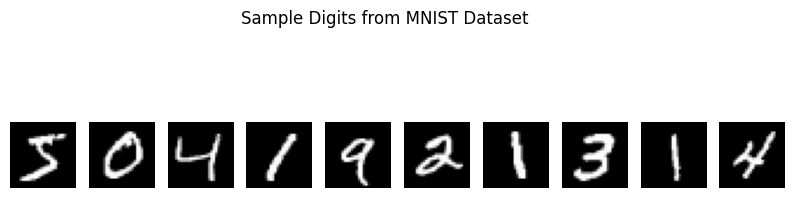


Class Distribution in Training Data:
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples


In [ ]:
# ----------------------------------------------------------
# 2. Load MNIST Dataset
# ----------------------------------------------------------

from tensorflow.keras.datasets import mnist

# Load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("MNIST Dataset Loaded Successfully.\n")

# ----------------------------------------------------------
# Dataset Shapes
# ----------------------------------------------------------

print("Training set images shape:", x_train.shape)
print("Training set labels shape:", y_train.shape)
print("Testing set images shape: ", x_test.shape)
print("Testing set labels shape: ", y_test.shape)

# ----------------------------------------------------------
# Display Basic Information
# ----------------------------------------------------------

num_classes = len(np.unique(y_train))
print("\nNumber of unique classes (digits):", num_classes)
print("Digit classes:", np.unique(y_train))
print("\nPixel value range: {} to {}".format(x_train.min(), x_train.max()))

# ----------------------------------------------------------
# Plot Sample Images
# ----------------------------------------------------------

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Sample Digits from MNIST Dataset")
plt.show()

# ----------------------------------------------------------
# Print Class Distribution
# ----------------------------------------------------------

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("\nClass Distribution in Training Data:")
for digit, count in class_distribution.items():
    print(f"Digit {digit}: {count} samples")

Pixel values normalized successfully.

Training data reshaped: (60000, 28, 28, 1)
Testing data reshaped:  (10000, 28, 28, 1)


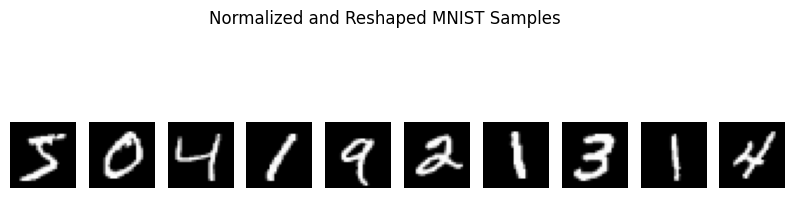

In [ ]:
# ----------------------------------------------------------
# 3. Preprocess MNIST Data
# ----------------------------------------------------------

# Convert pixel values 0–255 → 0–1
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm = x_test.astype("float32") / 255.0

print("Pixel values normalized successfully.\n")

# ----------------------------------------------------------
# Reshape images for CNN: (28, 28, 1)
# ----------------------------------------------------------

x_train_norm = x_train_norm.reshape(-1, 28, 28, 1)
x_test_norm = x_test_norm.reshape(-1, 28, 28, 1)

print("Training data reshaped:", x_train_norm.shape)
print("Testing data reshaped: ", x_test_norm.shape)

# ----------------------------------------------------------
# Display a few preprocessed images
# ----------------------------------------------------------

plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train_norm[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Normalized and Reshaped MNIST Samples")
plt.show()

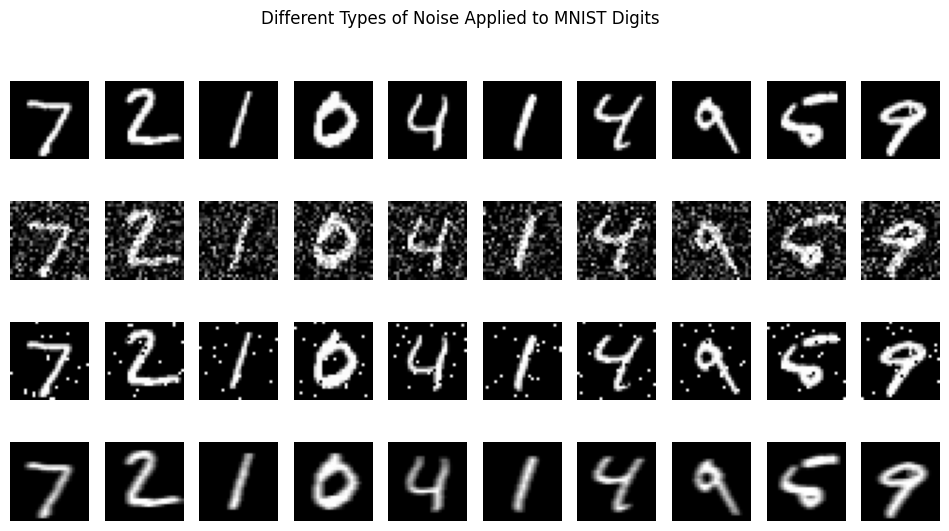

Noise generation complete.


In [ ]:
# ----------------------------------------------------------
# 4. Add Noise to MNIST Images
# ----------------------------------------------------------

# Ensure image is 2D (28x28)
def to_2d(image):
    if image.ndim == 3:
        return image.reshape(28, 28)
    return image


# --------------------------
# Gaussian Noise Function
# --------------------------
def add_gaussian_noise(image, mean=0, var=0.1):
    image = to_2d(image)
    sigma = var ** 0.5
    gaussian = np.random.normal(mean, sigma, image.shape)
    noisy = image + gaussian
    noisy = np.clip(noisy, 0.0, 1.0)
    return noisy.reshape(28, 28, 1)


# --------------------------
# Salt-and-Pepper Noise (FIXED)
# --------------------------
def add_salt_pepper_noise(image, amount=0.05):
    image = to_2d(image)
    noisy = np.copy(image)

    num_salt = int(amount * image.size * 0.5)
    num_pepper = int(amount * image.size * 0.5)

    # Salt (white pixels)
    coords_salt = (
        np.random.randint(0, 28, num_salt),
        np.random.randint(0, 28, num_salt)
    )
    noisy[coords_salt] = 1.0

    # Pepper (black pixels)
    coords_pepper = (
        np.random.randint(0, 28, num_pepper),
        np.random.randint(0, 28, num_pepper)
    )
    noisy[coords_pepper] = 0.0

    return noisy.reshape(28, 28, 1)


# --------------------------
# Motion Blur Noise (FIXED)
# --------------------------
def add_motion_blur(image, kernel_size=3):
    image = to_2d(image)

    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = 1.0 / kernel_size

    blurred = cv2.filter2D(image, -1, kernel)

    return blurred.reshape(28, 28, 1)


# ----------------------------------------------------------
# Generate Noisy Versions of a Sample Batch
# ----------------------------------------------------------

sample_images = x_test_norm[:10]

gaussian_noisy_images = [add_gaussian_noise(img) for img in sample_images]
sp_noisy_images = [add_salt_pepper_noise(img) for img in sample_images]
motion_noisy_images = [add_motion_blur(img) for img in sample_images]


# ----------------------------------------------------------
# Visualize All Noise Types
# ----------------------------------------------------------

plt.figure(figsize=(12, 6))

for i in range(10):
    # Original
    plt.subplot(4, 10, i + 1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Original")

    # Gaussian
    plt.subplot(4, 10, i + 11)
    plt.imshow(gaussian_noisy_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Gaussian")

    # Salt & Pepper
    plt.subplot(4, 10, i + 21)
    plt.imshow(sp_noisy_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Salt\nPepper")

    # Motion Blur
    plt.subplot(4, 10, i + 31)
    plt.imshow(motion_noisy_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Motion\nBlur")

plt.suptitle("Different Types of Noise Applied to MNIST Digits")
plt.show()

print("Noise generation complete.")

In [ ]:
# ----------------------------------------------------------
# 5. PREPROCESSING & AUGMENTATION PIPELINE
# ----------------------------------------------------------

import tensorflow as tf
import numpy as np
import cv2

# ----------------------------------------------------------
# NORMALIZATION (Already Done, but included for pipeline)
# ----------------------------------------------------------

def normalize_image(img):
    img = img.astype("float32") / 255.0
    return img


# ----------------------------------------------------------
# NOISE REDUCTION FUNCTIONS
# ----------------------------------------------------------

def reduce_gaussian_noise(img):
    img = img.reshape(28, 28)
    denoised = cv2.GaussianBlur(img, (3, 3), 0)
    return denoised.reshape(28, 28, 1)

def reduce_median_noise(img):
    img = img.reshape(28, 28)
    denoised = cv2.medianBlur((img * 255).astype("uint8"), 3)
    return (denoised.astype("float32") / 255.0).reshape(28, 28, 1)

def reduce_bilateral_noise(img):
    img = img.reshape(28, 28)
    denoised = cv2.bilateralFilter((img * 255).astype("uint8"), 5, 75, 75)
    return (denoised.astype("float32") / 255.0).reshape(28, 28, 1)


# ----------------------------------------------------------
# DATA AUGMENTATION USING TENSORFLOW FUNCTIONS
# ----------------------------------------------------------

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1)
], name="augmentation_layer")


# ----------------------------------------------------------
# FULL PREPROCESSING PIPELINE FUNCTION
# (Clean → Denoise → Augment → Normalize)
# ----------------------------------------------------------

def preprocess_image(img, apply_augmentation=True, denoise_method="median"):

    # Ensure correct shape
    if img.ndim == 2:
        img = img.reshape(28, 28, 1)

    # Normalize
    img = img.astype("float32")

    # Denoise
    if denoise_method == "gaussian":
        img = reduce_gaussian_noise(img)
    elif denoise_method == "bilateral":
        img = reduce_bilateral_noise(img)
    else:
        img = reduce_median_noise(img)

    # Augmentation (only for training)
    if apply_augmentation:
        img = data_augmentation(tf.expand_dims(img, 0))
        img = tf.squeeze(img, axis=0)

    return img


print("Preprocessing & augmentation pipeline created successfully.")

Preprocessing & augmentation pipeline created successfully.


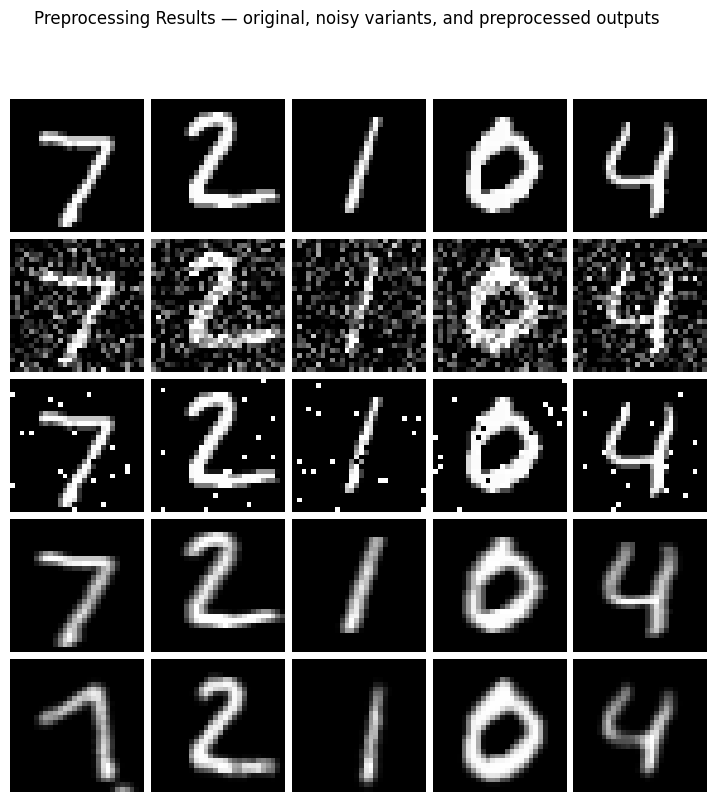

Visualization complete. All images converted to numpy and displayed.


In [ ]:
# ----------------------------------------------------------
# 6. Visualize Preprocessed Images (convert tensors -> numpy)
# ----------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Helper: convert image (tf.Tensor or np.ndarray) -> 2D numpy array (28x28)
def to_display_array(img):
    # If it's a TensorFlow tensor, convert to numpy
    if isinstance(img, tf.Tensor):
        arr = img.numpy()
    else:
        arr = np.array(img)
    # Remove channel dim if present
    if arr.ndim == 3 and arr.shape[-1] == 1:
        arr = arr.reshape(arr.shape[0], arr.shape[1])
    elif arr.ndim == 4 and arr.shape[-1] == 1:  # batch x h x w x 1
        arr = arr[0].reshape(arr.shape[1], arr.shape[2])
    elif arr.ndim == 3 and arr.shape[0] == 1:  # 1 x h x w
        arr = arr[0]
    return arr

# Select 5 images from the test set
sample_clean = x_test_norm[:5]

# Create noisy versions using earlier functions
sample_gaussian_noisy = [add_gaussian_noise(img) for img in sample_clean]
sample_sp_noisy      = [add_salt_pepper_noise(img) for img in sample_clean]
sample_motion_noisy  = [add_motion_blur(img) for img in sample_clean]

# Apply preprocessing pipeline (median denoising + augmentation)
# preprocess_image may return a tf.Tensor because augmentation is a TF layer -> convert immediately to numpy
preprocessed_clean = [preprocess_image(img, apply_augmentation=True) for img in sample_clean]
preprocessed_clean = [p.numpy() if isinstance(p, tf.Tensor) else p for p in preprocessed_clean]

preprocessed_gaussian = [preprocess_image(img, apply_augmentation=True) for img in sample_gaussian_noisy]
preprocessed_gaussian = [p.numpy() if isinstance(p, tf.Tensor) else p for p in preprocessed_gaussian]

preprocessed_sp = [preprocess_image(img, apply_augmentation=True) for img in sample_sp_noisy]
preprocessed_sp = [p.numpy() if isinstance(p, tf.Tensor) else p for p in preprocessed_sp]

preprocessed_motion = [preprocess_image(img, apply_augmentation=True) for img in sample_motion_noisy]
preprocessed_motion = [p.numpy() if isinstance(p, tf.Tensor) else p for p in preprocessed_motion]

# ----------------------------------------------------------
# Plot the results (5 rows x 5 cols)
# ----------------------------------------------------------

fig, axes = plt.subplots(5, 5, figsize=(9, 9))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

rows = [
    ("Original Clean", sample_clean),
    ("Gaussian Noisy", sample_gaussian_noisy),
    ("Salt & Pepper", sample_sp_noisy),
    ("Motion Blur", sample_motion_noisy),
    ("Preprocessed Clean", preprocessed_clean)
]

for r, (title, images) in enumerate(rows):
    for c in range(5):
        img = images[c]
        arr = to_display_array(img)
        axes[r, c].imshow(arr, cmap="gray")
        axes[r, c].axis("off")
        if c == 0:
            axes[r, c].set_ylabel(title, fontsize=9)

plt.suptitle("Preprocessing Results — original, noisy variants, and preprocessed outputs", fontsize=12)
plt.show()

print("Visualization complete. All images converted to numpy and displayed.")

In [ ]:
# ----------------------------------------------------------
# A1: BASELINE CNN MODEL (Clean MNIST Only)
# ----------------------------------------------------------

from tensorflow.keras import layers, models

# Model Architecture
baseline_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(10, activation='softmax')
])

# Compile Model
baseline_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ----------------------------------------------------------
# A2: TRAIN BASELINE CNN
# ----------------------------------------------------------

history_baseline = baseline_cnn.fit(
    x_train_norm, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8369 - loss: 0.5578 - val_accuracy: 0.9810 - val_loss: 0.0658
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9752 - loss: 0.0797 - val_accuracy: 0.9837 - val_loss: 0.0533
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9837 - loss: 0.0539 - val_accuracy: 0.9902 - val_loss: 0.0347
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9870 - loss: 0.0416 - val_accuracy: 0.9897 - val_loss: 0.0333
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9899 - loss: 0.0332 - val_accuracy: 0.9892 - val_loss: 0.0407
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9901 - loss: 0.0291 - val_accuracy: 0.9917 - val_loss: 0.0335
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9930 - loss: 0.0218 - val_accuracy: 0.9910 - val_loss: 0.0362
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9933 - loss: 0.0221 - val_accuracy: 

In [ ]:
# ----------------------------------------------------------
# A3: BASELINE EVALUATION
# ----------------------------------------------------------

test_loss, test_acc = baseline_cnn.evaluate(x_test_norm, y_test, verbose=0)

print(f"Baseline CNN Accuracy on Clean Test Images: {test_acc * 100:.2f}%")
print(f"Baseline CNN Loss: {test_loss:.4f}")

Baseline CNN Accuracy on Clean Test Images: 98.95%
Baseline CNN Loss: 0.0327


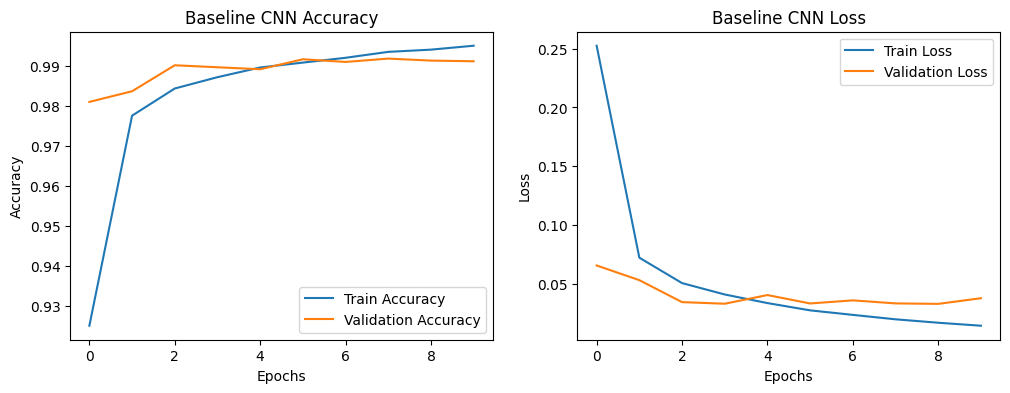

In [ ]:
# ----------------------------------------------------------
# Plot Training Curves
# ----------------------------------------------------------

plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'], label='Train Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title("Baseline CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'], label='Train Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title("Baseline CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report - Baseline CNN (Clean Test Images):

              precision    recall  f1-score   support

           0     0.9899    0.9980    0.9939       980
           1     0.9956    0.9965    0.9960      1135
           2     0.9883    0.9864    0.9874      1032
           3     0.9824    0.9960    0.9892      1010
           4     0.9959    0.9908    0.9934       982
           5     0.9844    0.9877    0.9860       892
           6     0.9958    0.9812    0.9884       958
           7     0.9865    0.9932    0.9898      1028
           8     0.9948    0.9743    0.9844       974
           9     0.9813    0.9891    0.9852      1009

    accuracy                         0.9895     10000
   macro avg     0.9895    0.9893    0.9894     10000
weighted avg     0.9895    0.9895    0.9895     10000



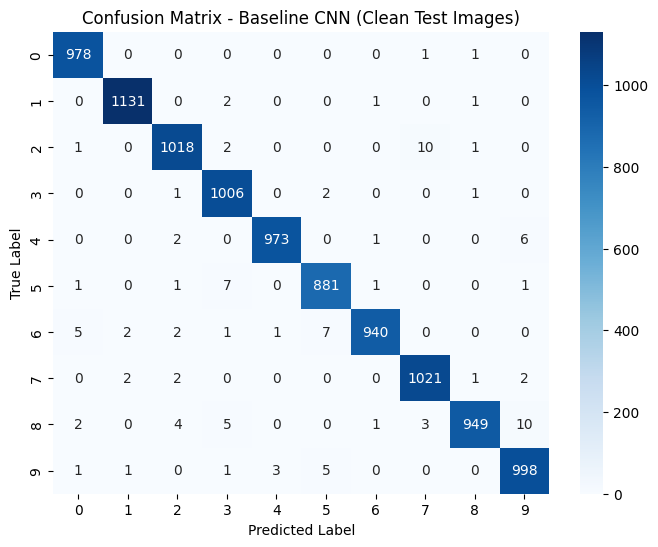

In [ ]:
# ----------------------------------------------------------
# CLASSIFICATION REPORT & CONFUSION MATRIX (BASELINE CNN)
# ----------------------------------------------------------
import seaborn as sns
# Predictions for clean test images
y_pred_baseline = baseline_cnn.predict(x_test_norm)
y_pred_baseline = np.argmax(y_pred_baseline, axis=1)

# Classification Report
print("Classification Report - Baseline CNN (Clean Test Images):\n")
print(classification_report(y_test, y_pred_baseline, digits=4))

# Confusion Matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Baseline CNN (Clean Test Images)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


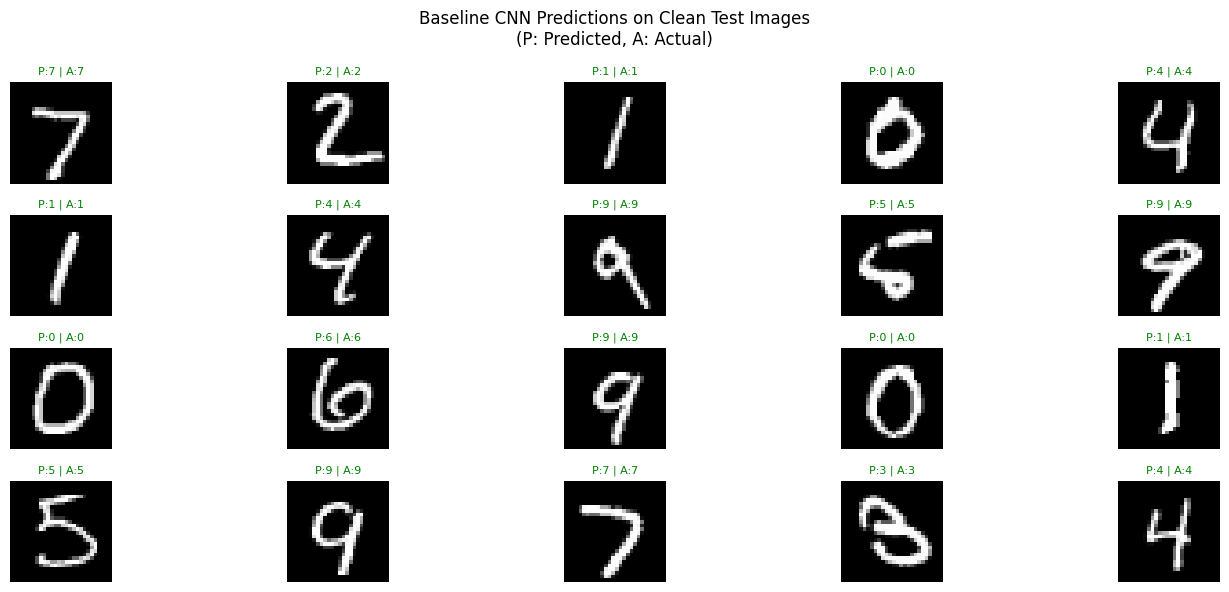

In [ ]:
# ----------------------------------------------------------
# SHOW PREDICTIONS ON MULTIPLE TEST IMAGES
# ----------------------------------------------------------

predictions = baseline_cnn.predict(x_test_norm)

num_images = 20  # Number of test samples to display
plt.figure(figsize=(15, 6))

for i in range(num_images):
    plt.subplot(4, 5, i+1)

    # Convert prediction vector to label
    predicted_label = np.argmax(predictions[i])
    actual_label = y_test[i]

    # Display image
    plt.imshow(x_test_norm[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Color coding: Green = correct, Red = incorrect
    color = "green" if predicted_label == actual_label else "red"
    plt.title(f"P:{predicted_label} | A:{actual_label}", color=color, fontsize=8)

plt.suptitle("Baseline CNN Predictions on Clean Test Images\n(P: Predicted, A: Actual)", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------------------------------------
# Generate noisy versions of the ENTIRE test set
# ----------------------------------------------------------

x_test_gaussian = np.array([add_gaussian_noise(img) for img in x_test_norm])
x_test_sp       = np.array([add_salt_pepper_noise(img) for img in x_test_norm])
x_test_motion   = np.array([add_motion_blur(img) for img in x_test_norm])

print("Noisy test sets created:")
print("Gaussian: ", x_test_gaussian.shape)
print("Salt & Pepper: ", x_test_sp.shape)
print("Motion Blur: ", x_test_motion.shape)

Noisy test sets created:
Gaussian:  (10000, 28, 28, 1)
Salt & Pepper:  (10000, 28, 28, 1)
Motion Blur:  (10000, 28, 28, 1)


In [ ]:
# ----------------------------------------------------------
# Evaluate baseline model on noisy test sets
# ----------------------------------------------------------

acc_gaussian = baseline_cnn.evaluate(x_test_gaussian, y_test, verbose=0)[1]
acc_sp       = baseline_cnn.evaluate(x_test_sp, y_test, verbose=0)[1]
acc_motion   = baseline_cnn.evaluate(x_test_motion, y_test, verbose=0)[1]

print("\nBaseline CNN Performance on Noisy Test Data:")
print(f"Gaussian Noise Accuracy:     {acc_gaussian * 100:.2f}%")
print(f"Salt & Pepper Noise Accuracy: {acc_sp * 100:.2f}%")
print(f"Motion Blur Accuracy:         {acc_motion * 100:.2f}%")


Baseline CNN Performance on Noisy Test Data:
Gaussian Noise Accuracy:     96.45%
Salt & Pepper Noise Accuracy: 98.17%
Motion Blur Accuracy:         98.25%


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


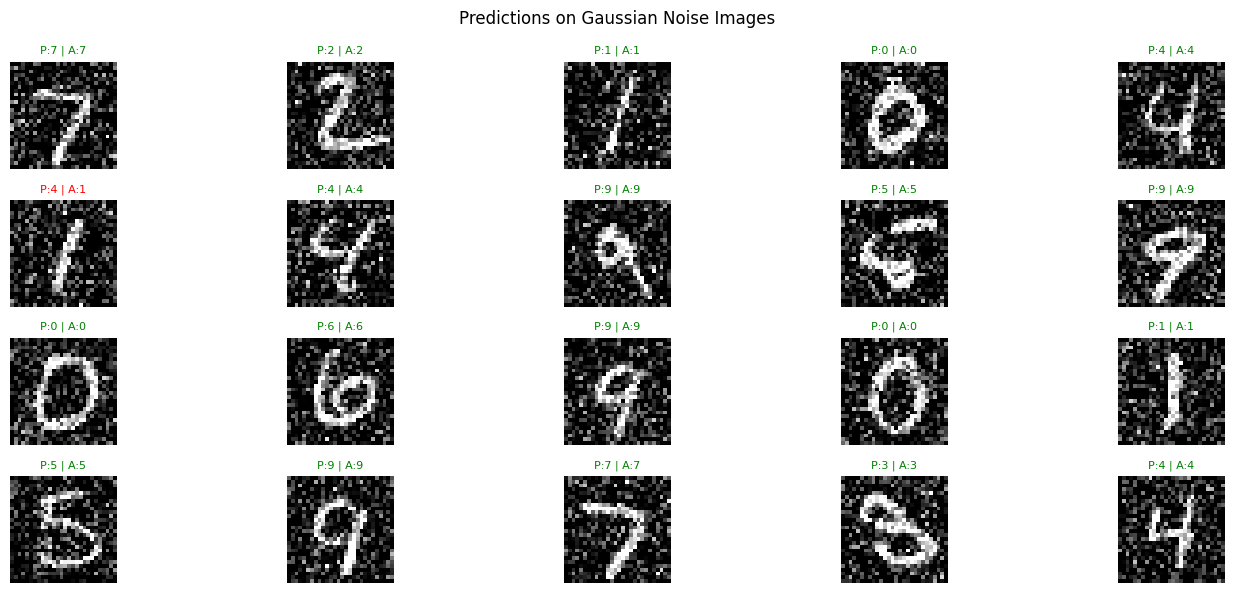

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


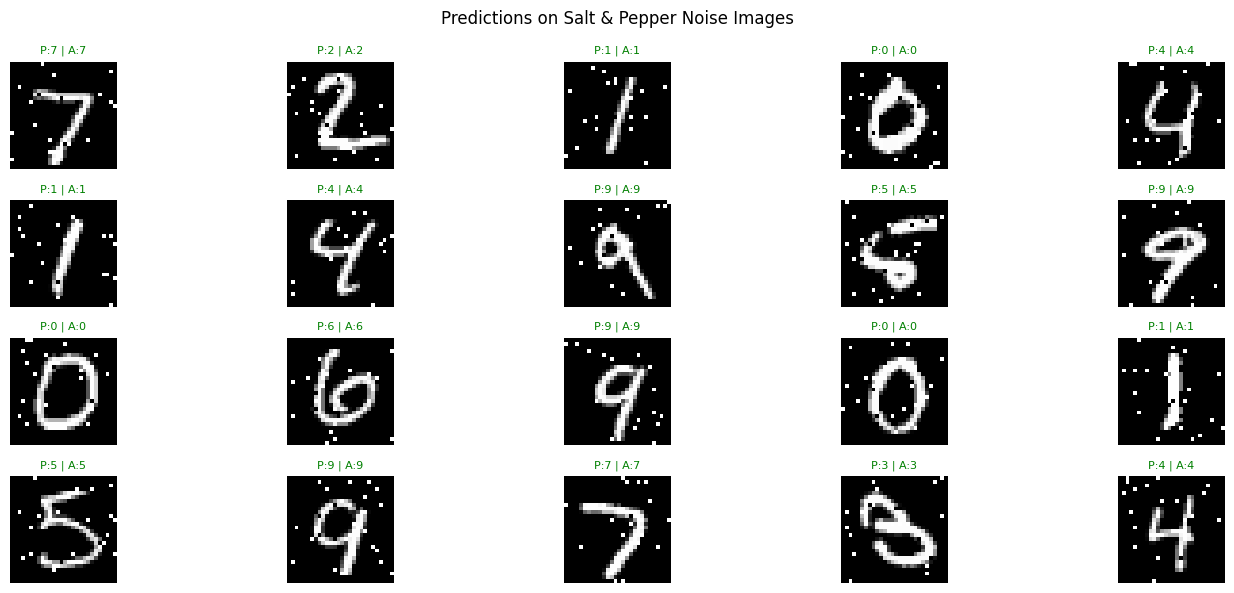

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


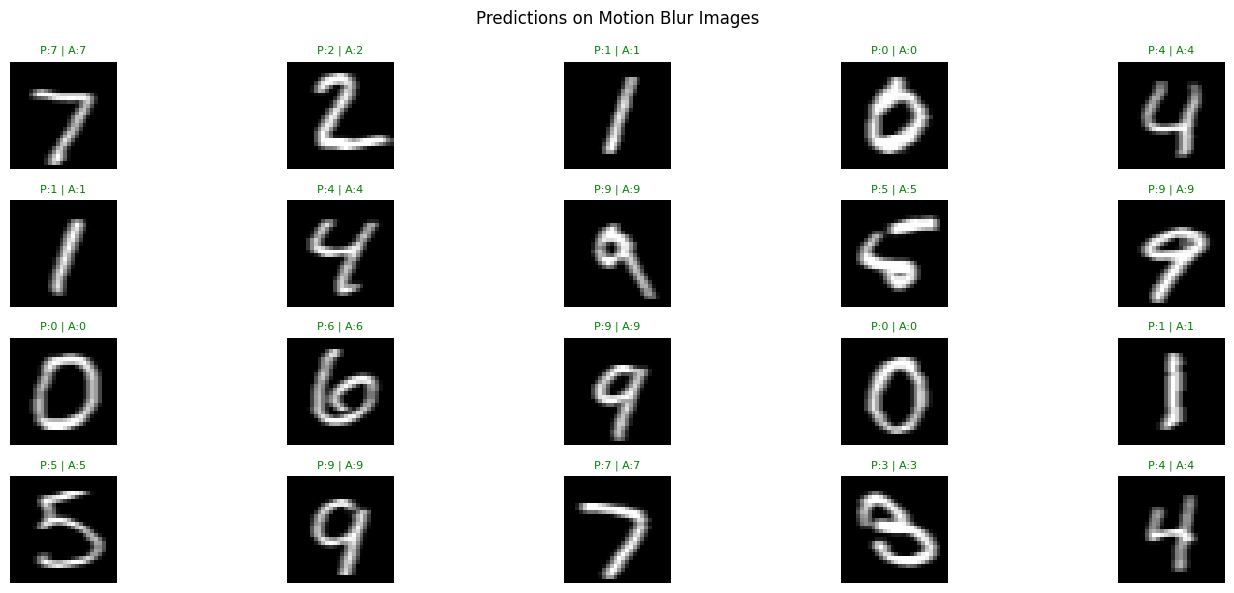

In [ ]:
# ----------------------------------------------------------
# Visual display of predictions on noisy test images
# ----------------------------------------------------------

def show_predictions_on_noisy(images, title):
    predictions = baseline_cnn.predict(images)

    plt.figure(figsize=(15, 6))
    for i in range(20):
        plt.subplot(4, 5, i+1)
        img_display = images[i].reshape(28, 28)
        plt.imshow(img_display, cmap='gray')
        plt.axis('off')

        pred_label = np.argmax(predictions[i])
        actual_label = y_test[i]

        color = "green" if pred_label == actual_label else "red"
        plt.title(f"P:{pred_label} | A:{actual_label}", color=color, fontsize=8)

    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


show_predictions_on_noisy(x_test_gaussian, "Predictions on Gaussian Noise Images")
show_predictions_on_noisy(x_test_sp, "Predictions on Salt & Pepper Noise Images")
show_predictions_on_noisy(x_test_motion, "Predictions on Motion Blur Images")

In [ ]:
# ----------------------------------------------------------
# Build the VAE model
# ----------------------------------------------------------

latent_dim = 16  # latent feature size

# ------------------ Encoder ------------------
encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling function
def sample_latent(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

z = layers.Lambda(sample_latent)([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


# ------------------ Decoder ------------------
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


# ------------------ VAE Model ------------------
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Losses
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, reconstruction))
            reconstruction_loss *= 28 * 28

            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss}


vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3136)      │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │    200,768 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      1,040 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      1,040 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 221,664 (865.88 KB)

 Trainable params: 221,664 (865.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ----------------------------------------------------------
# Train the VAE
# ----------------------------------------------------------

vae.fit(x_train_norm, epochs=30, batch_size=256, verbose=1)
print("VAE Training complete.")

Epoch 1/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 215.8390
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 124.5250
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 90.2486
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 82.6928
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 78.9290
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 76.6378
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 74.8000
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 73.4400
Epoch 9/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 72.5140
Epoch 10/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 71.8558
Epoch 11/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 71.2275
Epoch 12/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 70.7374
Epoch 13/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 70.2788
Epoch 14/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 69.9731
Epoch 15/30
235/235 ━━━━━━

In [ ]:
# ----------------------------------------------------------
# Generate Synthetic Digits
# ----------------------------------------------------------

num_generate = 100000
latent_samples = np.random.normal(size=(num_generate, latent_dim))
synthetic_digits = decoder.predict(latent_samples)
synthetic_digits = synthetic_digits.reshape(-1, 28, 28, 1)

print("Synthetic digits generated:", synthetic_digits.shape)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Synthetic digits generated: (100000, 28, 28, 1)


In [ ]:
# ----------------------------------------------------------
# REBUILD ROBUST CNN MODEL
# ----------------------------------------------------------

from tensorflow.keras import layers, models

robust_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

robust_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

robust_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ----------------------------------------------------------
# Pseudo Label Synthetic Digits using Robust CNN
# ----------------------------------------------------------

synthetic_preds = robust_cnn.predict(synthetic_digits)
synthetic_labels = np.argmax(synthetic_preds, axis=1)

print("Synthetic labels assigned:", synthetic_labels.shape)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Synthetic labels assigned: (100000,)


In [ ]:
# ----------------------------------------------------------
# FAST DATASET CREATION (100K images total)
# ----------------------------------------------------------

subset = 20000  # clean samples to use

clean_subset = x_train_norm[:subset]
clean_labels = y_train[:subset]

noisy_gaussian = np.array([add_gaussian_noise(img) for img in clean_subset])
noisy_sp = np.array([add_salt_pepper_noise(img) for img in clean_subset])
noisy_motion = np.array([add_motion_blur(img) for img in clean_subset])

# Combine noisy types
noisy_images = np.concatenate([noisy_gaussian, noisy_sp, noisy_motion], axis=0)
noisy_labels = np.concatenate([clean_labels]*3, axis=0)

# Combine clean + noisy
X_fast = np.concatenate([clean_subset, noisy_images], axis=0)
y_fast = np.concatenate([clean_labels, noisy_labels], axis=0)

# Shuffle
shuffle_idx = np.random.permutation(len(X_fast))
X_fast = X_fast[shuffle_idx]
y_fast = y_fast[shuffle_idx]

print("\nFast dataset created!")
print("X_fast shape:", X_fast.shape)
print("y_fast shape:", y_fast.shape)


Fast dataset created!
X_fast shape: (80000, 28, 28, 1)
y_fast shape: (80000,)


In [ ]:
# ----------------------------------------------------------
# Create Final Training Dataset
# ----------------------------------------------------------

X_final = np.concatenate([X_fast, synthetic_digits], axis=0)
y_final = np.concatenate([y_fast, synthetic_labels], axis=0)

# Shuffle dataset
shuffle_idx = np.random.permutation(len(X_final))
X_final = X_final[shuffle_idx]
y_final = y_final[shuffle_idx]

print("Final dataset created:", X_final.shape, y_final.shape)


Final dataset created: (180000, 28, 28, 1) (180000,)


In [ ]:
history_fast = robust_cnn.fit(
    X_fast, y_fast,
    epochs=10,             # Faster training
    batch_size=512,        # GPU optimized
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7074 - loss: 0.9604 - val_accuracy: 0.9610 - val_loss: 0.1260
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9584 - loss: 0.1394 - val_accuracy: 0.9799 - val_loss: 0.0675
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9750 - loss: 0.0873 - val_accuracy: 0.9869 - val_loss: 0.0459
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9792 - loss: 0.0652 - val_accuracy: 0.9869 - val_loss: 0.0378
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9849 - loss: 0.0474 - val_accuracy: 0.9905 - val_loss: 0.0295
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9871 - loss: 0.0411 - val_accuracy: 0.9916 - val_loss: 0.0246
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9897 - loss: 0.0320 - val_accuracy: 0.9939 - val_loss: 0.0174
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9914 - loss: 0.0265 - val_acc

In [ ]:
# ----------------------------------------------------------
# EVALUATE ROBUST CNN ON CLEAN + NOISY TEST DATA
# ----------------------------------------------------------

loss_clean, acc_clean = robust_cnn.evaluate(x_test_norm, y_test, verbose=0)
loss_gauss, acc_gauss = robust_cnn.evaluate(x_test_gaussian, y_test, verbose=0)
loss_sp, acc_sp = robust_cnn.evaluate(x_test_sp, y_test, verbose=0)
loss_motion, acc_motion = robust_cnn.evaluate(x_test_motion, y_test, verbose=0)

print("\nFast Robust CNN Evaluation:")
print(f"Clean MNIST Accuracy:       {acc_clean * 100:.2f}%")
print(f"Gaussian Noise Accuracy:    {acc_gauss * 100:.2f}%")
print(f"Salt & Pepper Accuracy:     {acc_sp * 100:.2f}%")
print(f"Motion Blur Accuracy:       {acc_motion * 100:.2f}%")


Fast Robust CNN Evaluation:
Clean MNIST Accuracy:       98.84%
Gaussian Noise Accuracy:    98.03%
Salt & Pepper Accuracy:     98.68%
Motion Blur Accuracy:       98.78%


In [ ]:
# ----------------------------------------------------------
# DISPLAY PREDICTIONS WITH ACTUAL LABELS (20 SAMPLES)
# ----------------------------------------------------------

def show_predictions(model, test_images, test_labels, title):
    predictions = model.predict(test_images)

    plt.figure(figsize=(15, 6))
    for i in range(20):  # Show first 20 test images
        plt.subplot(4, 5, i + 1)

        plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        pred_label = np.argmax(predictions[i])
        actual_label = test_labels[i]

        color = "green" if pred_label == actual_label else "red"
        plt.title(f"P:{pred_label} | A:{actual_label}", fontsize=8, color=color)

    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


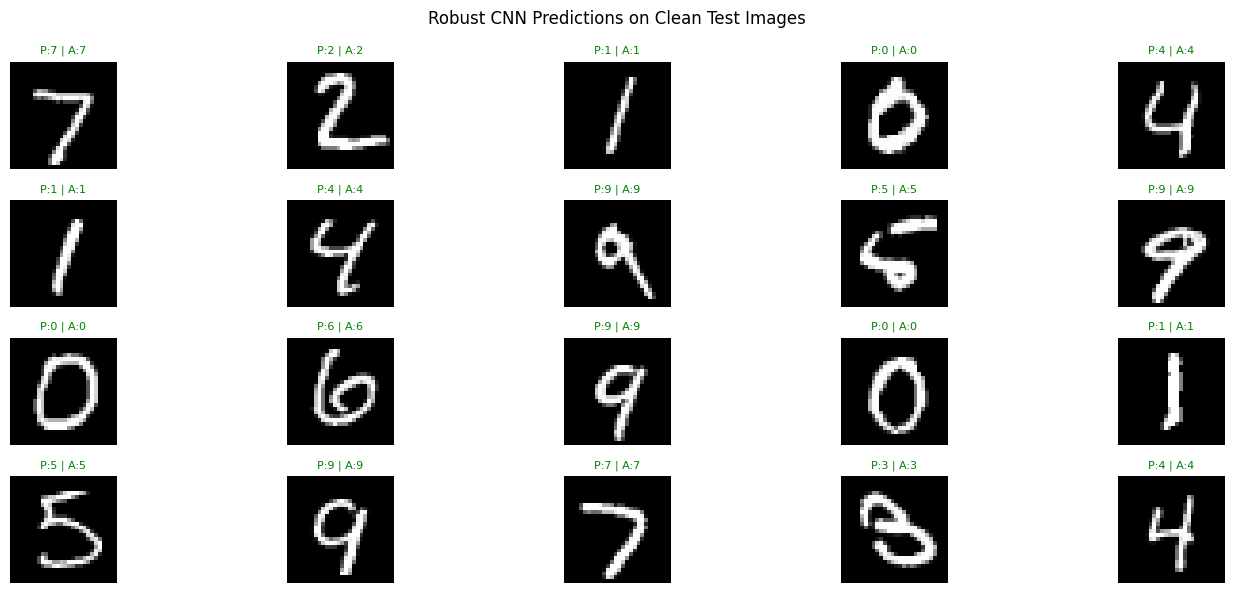

In [ ]:
show_predictions(
    robust_cnn,
    x_test_norm,
    y_test,
    "Robust CNN Predictions on Clean Test Images"
)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


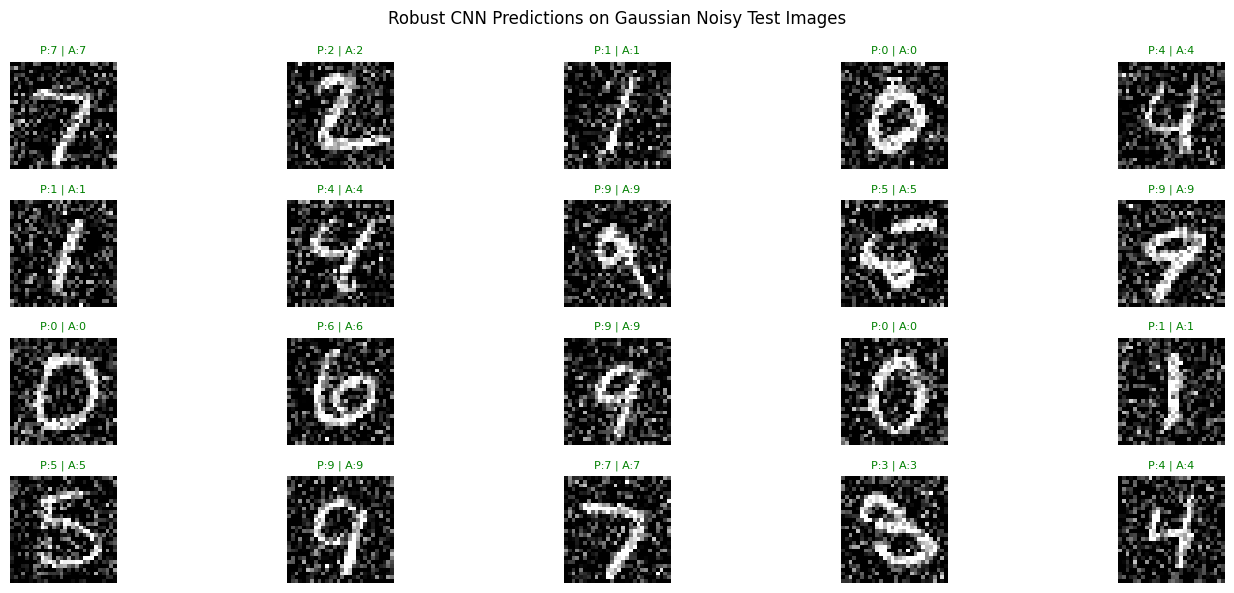

In [ ]:
show_predictions(
    robust_cnn,
    x_test_gaussian,
    y_test,
    "Robust CNN Predictions on Gaussian Noisy Test Images"
)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


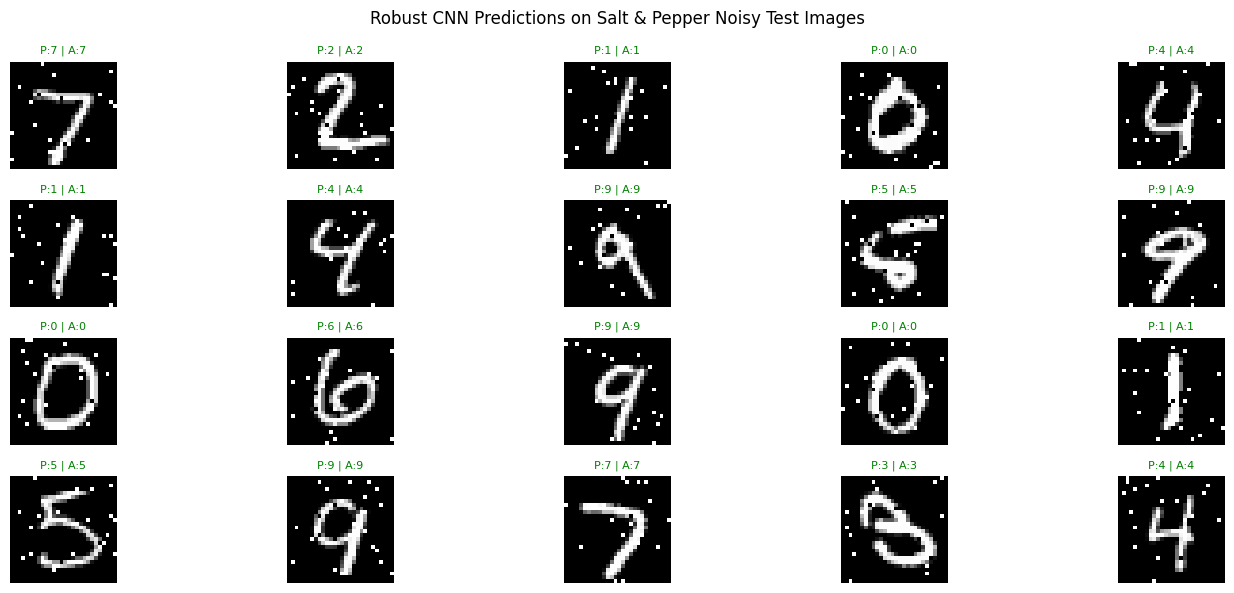

In [ ]:
show_predictions(
    robust_cnn,
    x_test_sp,
    y_test,
    "Robust CNN Predictions on Salt & Pepper Noisy Test Images"
)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


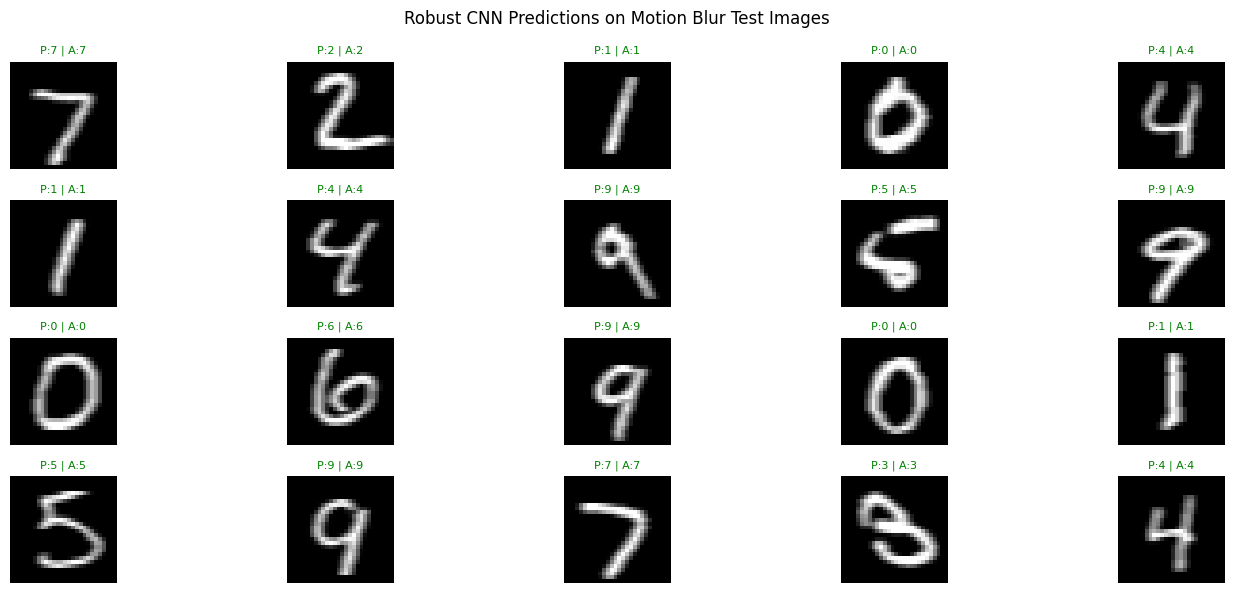

In [ ]:
show_predictions(
    robust_cnn,
    x_test_motion,
    y_test,
    "Robust CNN Predictions on Motion Blur Test Images"
)


In [ ]:
# ----------------------------------------------------------
# FINAL CNN TRAINING (CLEAN + NOISY + SYNTHETIC)
# ----------------------------------------------------------

from tensorflow.keras import layers, models

final_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

final_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_cnn.summary()


history_final = final_cnn.fit(
    X_final, y_final,
    epochs=10,
    batch_size=512,
    validation_split=0.1,
    verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 824,842 (3.15 MB)

 Trainable params: 824,650 (3.15 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.7118 - loss: 1.0348 - val_accuracy: 0.5672 - val_loss: 1.5937
Epoch 2/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8910 - loss: 0.3010 - val_accuracy: 0.9077 - val_loss: 0.2389
Epoch 3/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9166 - loss: 0.2238 - val_accuracy: 0.9188 - val_loss: 0.2126
Epoch 4/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9280 - loss: 0.1895 - val_accuracy: 0.9286 - val_loss: 0.1849
Epoch 5/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9333 - loss: 0.1723 - val_accuracy: 0.9357 - val_loss: 0.1640
Epoch 6/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9369 - loss: 0.1600 - val_accuracy: 0.9371 - val_loss: 0.1591
Epoch 7/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9420 - loss: 0.1486 - val_accuracy: 0.9382 - val_loss: 0.1509
Epoch 8/10
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9452 - loss: 0.1390 - val_acc

In [ ]:
# ----------------------------------------------------------
# FINAL MODEL EVALUATION
# ----------------------------------------------------------

clean_loss, clean_acc = final_cnn.evaluate(x_test_norm, y_test, verbose=0)
gauss_loss, gauss_acc = final_cnn.evaluate(x_test_gaussian, y_test, verbose=0)
sp_loss, sp_acc = final_cnn.evaluate(x_test_sp, y_test, verbose=0)
motion_loss, motion_acc = final_cnn.evaluate(x_test_motion, y_test, verbose=0)

print("\nFINAL MODEL PERFORMANCE:")
print(f"Clean Test Accuracy:        {clean_acc * 100:.2f}%")
print(f"Gaussian Noise Accuracy:    {gauss_acc * 100:.2f}%")
print(f"Salt & Pepper Accuracy:     {sp_acc * 100:.2f}%")
print(f"Motion Blur Accuracy:       {motion_acc * 100:.2f}%")


FINAL MODEL PERFORMANCE:
Clean Test Accuracy:        97.97%
Gaussian Noise Accuracy:    97.70%
Salt & Pepper Accuracy:     98.15%
Motion Blur Accuracy:       98.29%


In [ ]:
# ----------------------------------------------------------
# VISUALIZE PREDICTIONS FOR FINAL CNN MODEL
# ----------------------------------------------------------

def show_predictions_final(model, test_images, test_labels, title):
    predictions = model.predict(test_images)

    plt.figure(figsize=(15, 6))

    for i in range(20):  # Show first 20 samples
        plt.subplot(4, 5, i + 1)
        plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        pred_label = np.argmax(predictions[i])
        actual_label = test_labels[i]

        # Green text if correct | Red if wrong
        color = "green" if pred_label == actual_label else "red"
        plt.title(f"P:{pred_label} | A:{actual_label}", color=color, fontsize=8)

    plt.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


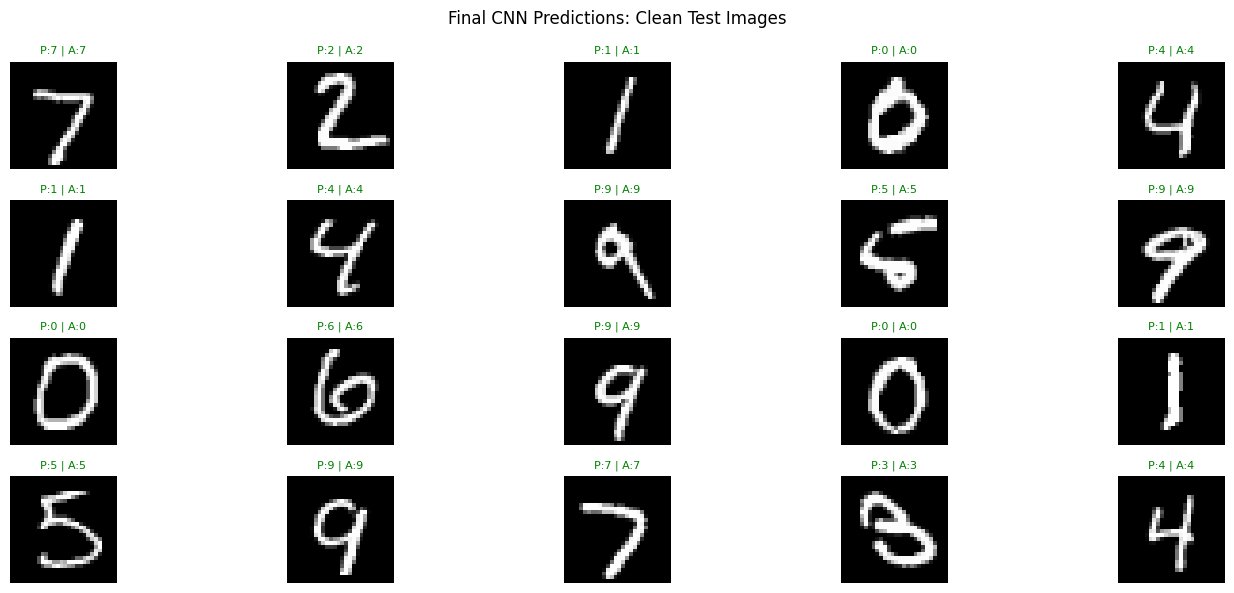

In [ ]:
show_predictions_final(
    final_cnn,
    x_test_norm,
    y_test,
    "Final CNN Predictions: Clean Test Images"
)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


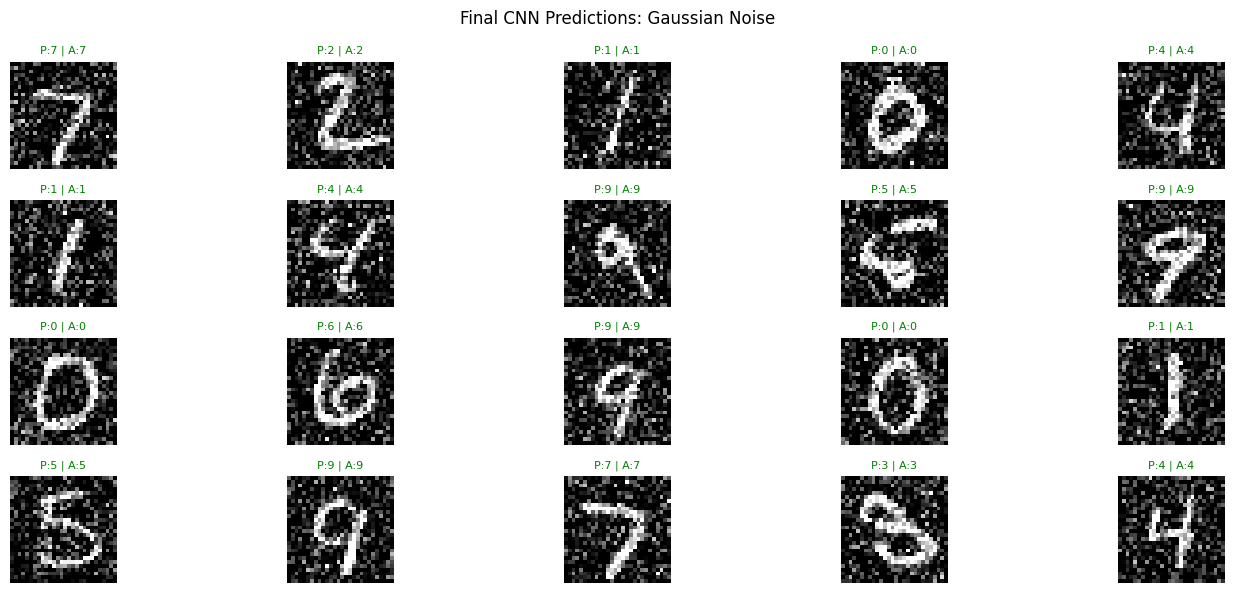

In [ ]:
show_predictions_final(
    final_cnn,
    x_test_gaussian,
    y_test,
    "Final CNN Predictions: Gaussian Noise"
)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


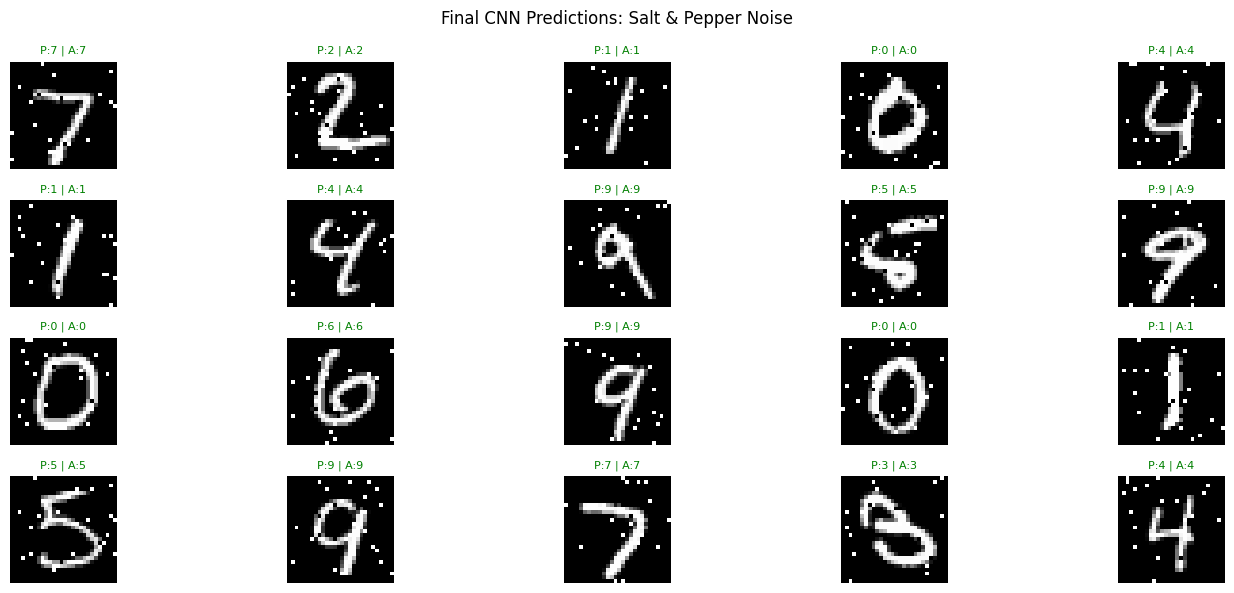

In [ ]:
show_predictions_final(
    final_cnn,
    x_test_sp,
    y_test,
    "Final CNN Predictions: Salt & Pepper Noise"
)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


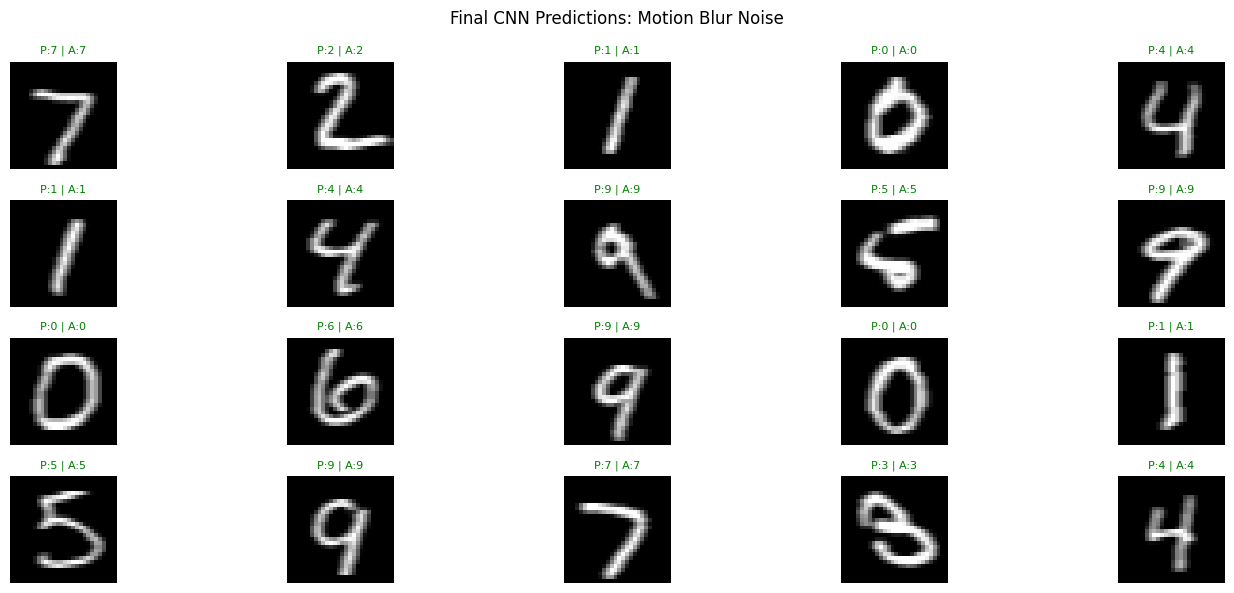

In [ ]:
show_predictions_final(
    final_cnn,
    x_test_motion,
    y_test,
    "Final CNN Predictions: Motion Blur Noise"
)



 Robust CNN - Clean Dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.981     0.997     0.989       980
           1      0.992     0.995     0.993      1135
           2      0.990     0.990     0.990      1032
           3      0.987     0.995     0.991      1010
           4      0.990     0.993     0.991       982
           5      0.985     0.983     0.984       892
           6      0.995     0.981     0.988       958
           7      0.987     0.983     0.985      1028
           8      0.990     0.983     0.986       974
           9      0.986     0.982     0.984      1009

    accuracy                          0.988     10000
   macro avg      0.988     0.988     0.988     10000
weighted avg      0.988     0.988     0.988     10000



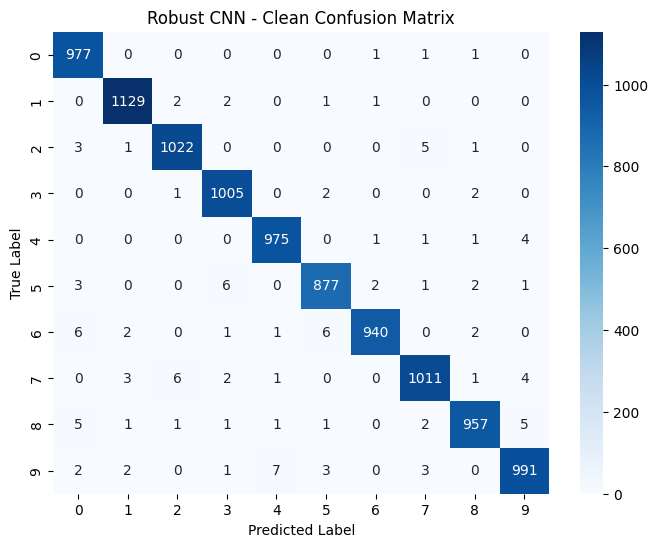


 Robust CNN - Gaussian Noise Dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.972     0.995     0.983       980
           1      0.990     0.994     0.992      1135
           2      0.983     0.979     0.981      1032
           3      0.978     0.988     0.983      1010
           4      0.986     0.986     0.986       982
           5      0.982     0.976     0.979       892
           6      0.997     0.972     0.984       958
           7      0.972     0.970     0.971      1028
           8      0.979     0.970     0.975       974
           9      0.964     0.971     0.967      1009

    accuracy                          0.980     10000
   macro avg      0.980     0.980     0.980     10000
weighted avg      0.980     0.980     0.980     10000



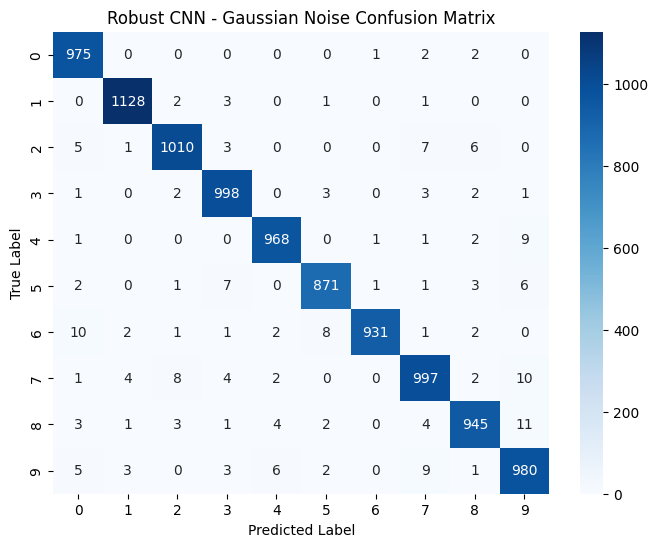


 Robust CNN - Salt & Pepper Noise Dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.983     0.995     0.989       980
           1      0.991     0.994     0.993      1135
           2      0.991     0.990     0.991      1032
           3      0.982     0.992     0.987      1010
           4      0.992     0.991     0.991       982
           5      0.985     0.982     0.984       892
           6      0.994     0.979     0.986       958
           7      0.985     0.981     0.983      1028
           8      0.986     0.983     0.984       974
           9      0.978     0.980     0.979      1009

    accuracy                          0.987     10000
   macro avg      0.987     0.987     0.987     10000
weighted avg      0.987     0.987     0.987     10000



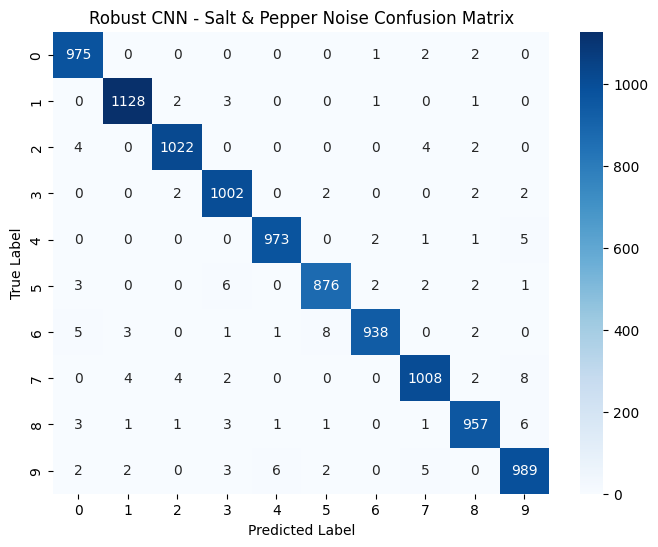


 Robust CNN - Motion Blur Noise Dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.986     0.996     0.991       980
           1      0.994     0.994     0.994      1135
           2      0.986     0.991     0.988      1032
           3      0.981     0.996     0.989      1010
           4      0.995     0.985     0.990       982
           5      0.983     0.983     0.983       892
           6      0.995     0.980     0.987       958
           7      0.987     0.983     0.985      1028
           8      0.990     0.982     0.986       974
           9      0.981     0.986     0.984      1009

    accuracy                          0.988     10000
   macro avg      0.988     0.988     0.988     10000
weighted avg      0.988     0.988     0.988     10000



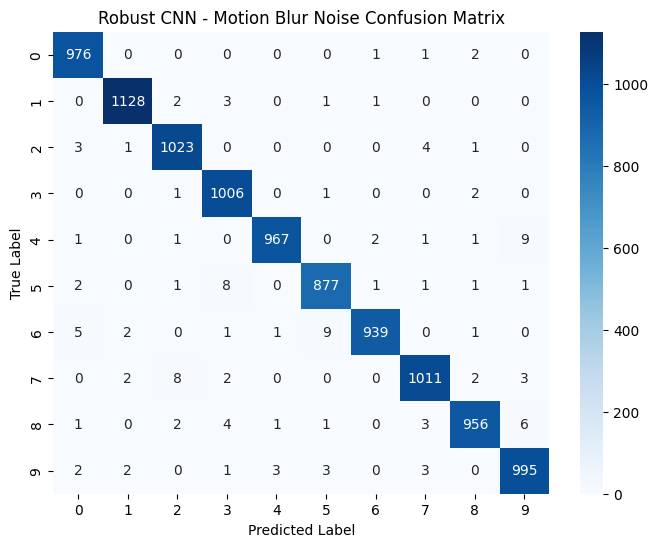


 Final CNN - Clean Dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.981     0.998     0.989       980
           1      0.990     0.992     0.991      1135
           2      0.993     0.974     0.983      1032
           3      0.981     0.984     0.983      1010
           4      0.988     0.981     0.984       982
           5      0.991     0.972     0.981       892
           6      0.994     0.978     0.986       958
           7      0.936     0.983     0.959      1028
           8      0.992     0.976     0.984       974
           9      0.956     0.956     0.956      1009

    accuracy                          0.980     10000
   macro avg      0.980     0.979     0.980     10000
weighted avg      0.980     0.980     0.980     10000



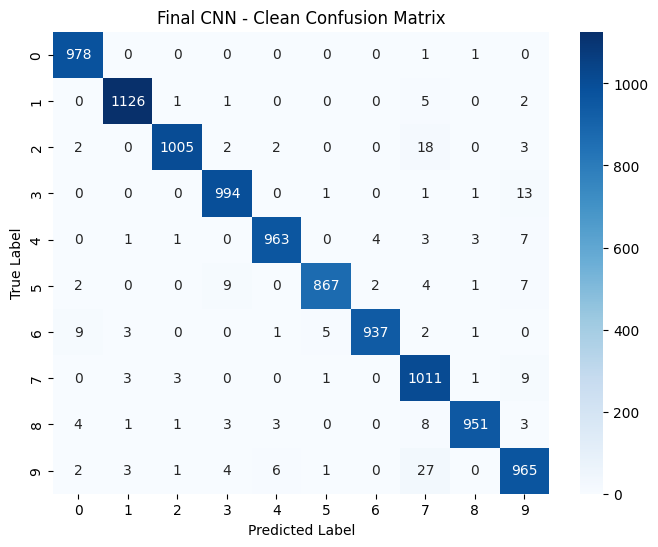


 Final CNN - Gaussian Noise Dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.977     0.995     0.986       980
           1      0.978     0.996     0.987      1135
           2      0.983     0.976     0.980      1032
           3      0.968     0.985     0.976      1010
           4      0.984     0.969     0.977       982
           5      0.983     0.979     0.981       892
           6      0.990     0.985     0.987       958
           7      0.964     0.971     0.968      1028
           8      0.985     0.966     0.976       974
           9      0.959     0.946     0.953      1009

    accuracy                          0.977     10000
   macro avg      0.977     0.977     0.977     10000
weighted avg      0.977     0.977     0.977     10000



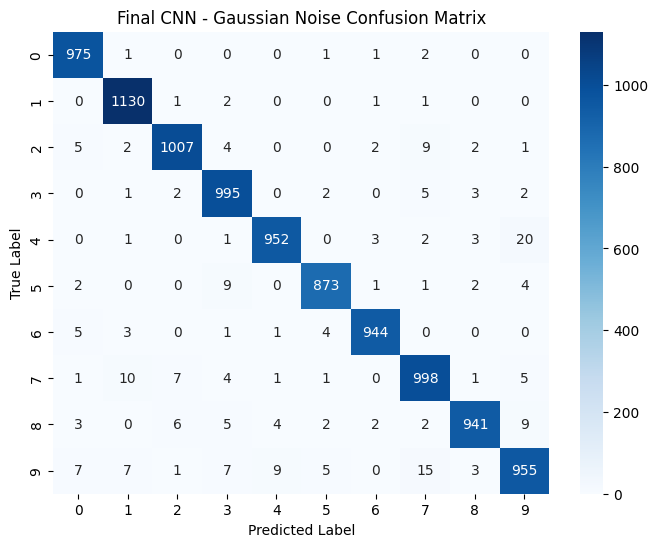


 Final CNN - Salt & Pepper Noise Dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.982     0.995     0.988       980
           1      0.981     0.996     0.988      1135
           2      0.989     0.979     0.984      1032
           3      0.974     0.990     0.982      1010
           4      0.985     0.984     0.984       982
           5      0.989     0.973     0.981       892
           6      0.992     0.978     0.985       958
           7      0.966     0.976     0.971      1028
           8      0.991     0.975     0.983       974
           9      0.970     0.967     0.969      1009

    accuracy                          0.982     10000
   macro avg      0.982     0.981     0.981     10000
weighted avg      0.982     0.982     0.981     10000



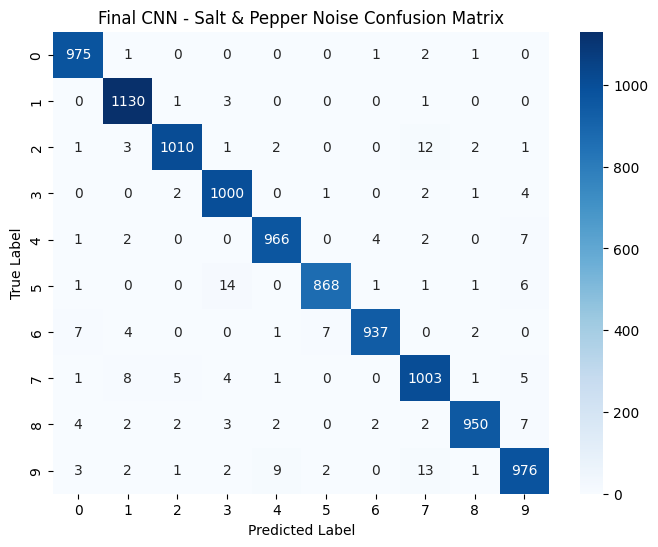


 Final CNN - Motion Blur Noise Dataset
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0      0.982     0.997     0.989       980
           1      0.989     0.994     0.991      1135
           2      0.991     0.977     0.984      1032
           3      0.986     0.989     0.988      1010
           4      0.990     0.983     0.986       982
           5      0.988     0.978     0.983       892
           6      0.994     0.978     0.986       958
           7      0.949     0.986     0.967      1028
           8      0.994     0.978     0.986       974
           9      0.971     0.967     0.969      1009

    accuracy                          0.983     10000
   macro avg      0.983     0.983     0.983     10000
weighted avg      0.983     0.983     0.983     10000



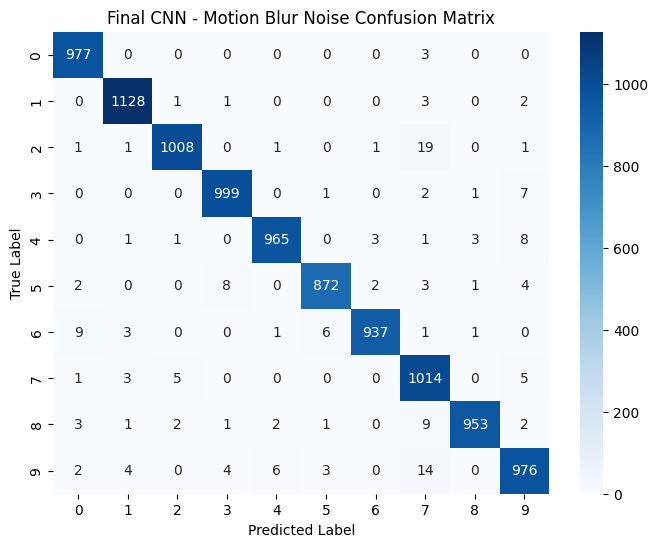

In [ ]:
# ----------------------------------------------------------
# FULL MODEL EVALUATION FOR ROBUST CNN & FINAL CNN
# ----------------------------------------------------------

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

models = {
    "Robust CNN": robust_cnn,
    "Final CNN": final_cnn
}

datasets = {
    "Clean": x_test_norm,
    "Gaussian Noise": x_test_gaussian,
    "Salt & Pepper Noise": x_test_sp,
    "Motion Blur Noise": x_test_motion
}

for model_name, model in models.items():
    for data_name, test_data in datasets.items():

        print(f"\n==============================")
        print(f" {model_name} - {data_name} Dataset")
        print(f"==============================")

        # Predictions
        y_pred = model.predict(test_data)
        y_pred = np.argmax(y_pred, axis=1)

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, digits=3))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)

        # Plot Heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{model_name} - {data_name} Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()


In [ ]:
# ----------------------------------------------------------
# PREPARE DATA FOR MACHINE LEARNING MODELS
# ----------------------------------------------------------

from sklearn.model_selection import train_test_split

# Use first 10,000 clean samples for classical ML (faster training)
ml_samples = 10000

X_ml = x_train_norm[:ml_samples].reshape(ml_samples, -1)
y_ml = y_train[:ml_samples]

X_test_ml = x_test_norm.reshape(x_test_norm.shape[0], -1)
y_test_ml = y_test

print("ML Training Data:", X_ml.shape, y_ml.shape)
print("ML Test Data:", X_test_ml.shape, y_test_ml.shape)

ML Training Data: (10000, 784) (10000,)
ML Test Data: (10000, 784) (10000,)


In [ ]:
# ----------------------------------------------------------
# MODEL A: KNN CLASSIFIER
# ----------------------------------------------------------

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_ml, y_ml)

knn_acc = knn.score(X_test_ml, y_test_ml)
print(f"KNN Accuracy: {knn_acc * 100:.2f}%")

KNN Accuracy: 94.63%


In [ ]:
# ----------------------------------------------------------
# MODEL B: SVM (Linear SVC)
# ----------------------------------------------------------

from sklearn.svm import LinearSVC
svm = LinearSVC(max_iter=2000)
svm.fit(X_ml, y_ml)

svm_acc = svm.score(X_test_ml, y_test_ml)
print(f"SVM Accuracy: {svm_acc * 100:.2f}%")

SVM Accuracy: 88.87%


In [ ]:
# ----------------------------------------------------------
# MODEL C: RANDOM FOREST
# ----------------------------------------------------------

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=120)
rf.fit(X_ml, y_ml)

rf_acc = rf.score(X_test_ml, y_test_ml)
print(f"Random Forest Accuracy: {rf_acc * 100:.2f}%")

Random Forest Accuracy: 94.97%


In [ ]:
# ----------------------------------------------------------
# EVALUATE CLASSICAL ML MODELS ON NOISY DATA
# ----------------------------------------------------------

# Flatten noisy datasets for ML evaluation
X_test_gaussian_ml = x_test_gaussian.reshape(x_test_gaussian.shape[0], -1)
X_test_sp_ml = x_test_sp.reshape(x_test_sp.shape[0], -1)
X_test_motion_ml = x_test_motion.reshape(x_test_motion.shape[0], -1)

# KNN
knn_gauss_acc = knn.score(X_test_gaussian_ml, y_test_ml)
knn_sp_acc = knn.score(X_test_sp_ml, y_test_ml)
knn_motion_acc = knn.score(X_test_motion_ml, y_test_ml)

# SVM
svm_gauss_acc = svm.score(X_test_gaussian_ml, y_test_ml)
svm_sp_acc = svm.score(X_test_sp_ml, y_test_ml)
svm_motion_acc = svm.score(X_test_motion_ml, y_test_ml)

# Random Forest
rf_gauss_acc = rf.score(X_test_gaussian_ml, y_test_ml)
rf_sp_acc = rf.score(X_test_sp_ml, y_test_ml)
rf_motion_acc = rf.score(X_test_motion_ml, y_test_ml)


print("\n========== Classical ML Performance on Noisy Data ==========\n")
print(f"KNN - Gaussian: {knn_gauss_acc * 100:.2f}% | Salt & Pepper: {knn_sp_acc * 100:.2f}% | Motion Blur: {knn_motion_acc * 100:.2f}%")
print(f"SVM - Gaussian: {svm_gauss_acc * 100:.2f}% | Salt & Pepper: {svm_sp_acc * 100:.2f}% | Motion Blur: {svm_motion_acc * 100:.2f}%")
print(f"RF  - Gaussian: {rf_gauss_acc * 100:.2f}% | Salt & Pepper: {rf_sp_acc * 100:.2f}% | Motion Blur: {rf_motion_acc * 100:.2f}%")


========== Classical ML Performance on Noisy Data ==========

KNN - Gaussian: 94.48% | Salt & Pepper: 94.53% | Motion Blur: 94.56%
SVM - Gaussian: 43.17% | Salt & Pepper: 69.95% | Motion Blur: 90.61%
RF  - Gaussian: 56.44% | Salt & Pepper: 94.58% | Motion Blur: 93.45%


In [ ]:
# ----------------------------------------------------------
# UPDATED FULL COMPARISON TABLE
# ----------------------------------------------------------

import pandas as pd
import numpy as np

comparison_results = {
    "Model": [
        "Baseline CNN",
        "Robust CNN",
        "Final CNN",
        "KNN",
        "SVM",
        "Random Forest"
    ],
    "Clean (%)": [
        test_acc * 100,
        acc_clean * 100,
        clean_acc * 100,
        knn_acc * 100,
        svm_acc * 100,
        rf_acc * 100
    ],
    "Gaussian Noise (%)": [
        acc_gaussian * 100,
        acc_gauss * 100,
        gauss_acc * 100,
        knn_gauss_acc * 100,
        svm_gauss_acc * 100,
        rf_gauss_acc * 100
    ],
    "Salt & Pepper (%)": [
        acc_sp * 100,
        acc_sp * 100,
        sp_acc * 100,
        knn_sp_acc * 100,
        svm_sp_acc * 100,
        rf_sp_acc * 100
    ],
    "Motion Blur (%)": [
        acc_motion * 100,
        acc_motion * 100,
        motion_acc * 100,
        knn_motion_acc * 100,
        svm_motion_acc * 100,
        rf_motion_acc * 100
    ]
}

comparison_df = pd.DataFrame(comparison_results)
print("\n=== FULL MODEL PERFORMANCE COMPARISON TABLE ===\n")
display(comparison_df)


=== FULL MODEL PERFORMANCE COMPARISON TABLE ===



,Model,Clean (%),Gaussian Noise (%),Salt & Pepper (%),Motion Blur (%)
0,Baseline CNN,98.949999,96.450001,98.680001,98.780000
1,Robust CNN,98.839998,98.030001,98.680001,98.780000
2,Final CNN,97.970003,97.700000,98.150003,98.290002
3,KNN,94.630000,94.480000,94.530000,94.560000
4,SVM,88.870000,43.170000,69.950000,90.610000
5,Random Forest,94.970000,56.440000,94.580000,93.450000
